In [1]:
import os
import json
import h5py
import numpy as np

import torch
from torch.utils.data import Dataset

### Check this...

https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/graves_handwriting_generation.ipynb

https://github.com/vrama91/coco-caption/blob/master/pycocoevalcap/eval.py

https://markroxor.github.io/gensim/static/notebooks/WMD_tutorial.html

`CocoDataset` should inherit `Dataset` and override the following methods:
- `__len__` so that len(dataset) returns the size of the dataset.
- `__getitem__` to support the indexing such that dataset[i] can be used to get i*th* sample

[Dataset Reference](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [2]:
import os
import json
import h5py
import numpy as np

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class COCODataset(Dataset):
    """
    COCO Dataset to be used in DataLoader for creating batches 
    during training.
    """
    def __init__(self, config, split='TRAIN', transform=None):
        self.config = config
        self.split = split
        self.transform = transform
        
        # Open files where images are stored in HDF5 data fromat, captions & their lengths
        if self.split == 'TRAIN':
            self.hdf5 = h5py.File(name=self.config.train_hdf5, mode='r')
            self.captions = self.read_json(self.config.train_captions)
        else:
            self.hdf5 = h5py.File(name=self.config.val_hdf5, mode='r')
            self.captions = self.read_json(self.config.val_captions)
            
        # Get image data
        self.images = self.hdf5['images']
                    
    def read_json(self, json_path):
        with open(json_path, 'r') as j:
            json_data = json.load(j)
        return json_data
        
    def __len__(self):
        return len(self.captions)
    
    def __getitem__(self, idx):
        img = torch.FloatTensor(self.images[idx])
        if self.transform is not None:
            img = self.transform(img)
         
        # There are 5 captions so randomly sample 1 caption
        cap_idx = np.random.randint(0, high=5)
        caption = torch.LongTensor(self.captions[idx][0][cap_idx])
        length = torch.LongTensor([self.captions[idx][1][cap_idx]])
        
        if self.split == 'TRAIN':
            return img, caption, length
        else:
            captions = torch.LongTensor(self.captions[idx][0])
            return img, caption, length, captions

In [3]:
class DataConfig(object):
    def __init__(self):
        
        # Training data
        self.train_hdf5 = './TRAIN_IMAGES_COCO.hdf5'
        self.train_captions = './TRAIN_CAPTIONS_COCO.json'
        
        # Validation data
        self.val_hdf5 = './VAL__IMAGES_COCO.hdf5'
        self.val_captions = './VAL_CROP_CAPTIONS_COCO.json'

In [4]:
# Train
config = DataConfig()
coco = COCODataset(config)

idx = 113286
print(coco[idx][0].shape) # Image
print(coco[idx][1].shape) # Sampled aption for the image
print(coco[idx][2].shape) # Sampled caption length for the image
print(len(coco))

torch.Size([3, 224, 224])
torch.Size([18])
torch.Size([1])
113287


In [5]:
# Validation 
config = DataConfig()
coco = COCODataset(config, split='VAL')

idx = 3
print(coco[idx][0].shape) # Image
print(coco[idx][1].shape) # Sampled aption for the image
print(coco[idx][2].shape) # Sampled caption length for the image
print(coco[idx][3].shape) # Captions for the image

torch.Size([3, 224, 224])
torch.Size([18])
torch.Size([1])
torch.Size([5, 18])


In [6]:
from torch.utils.data import DataLoader

val_loader = DataLoader(coco, batch_size=1, shuffle=True)

In [7]:
for i, data in enumerate(val_loader):
    if i == 0:
        break
        
print(len(data))
print(data[0].shape) # images
print(data[1].shape) # captions
print(data[2].shape) # lengths

4
torch.Size([1, 3, 224, 224])
torch.Size([1, 18])
torch.Size([1, 1])


# Scratch

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import imageio
from skimage.transform import resize

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

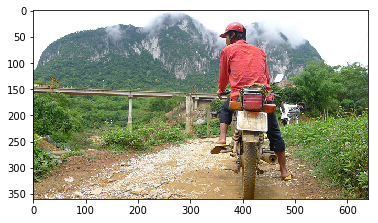

In [9]:
img_path = './val2014/COCO_val2014_000000391895.jpg'
img = imageio.imread(img_path)
plt.imshow(img)

dtype('float64')

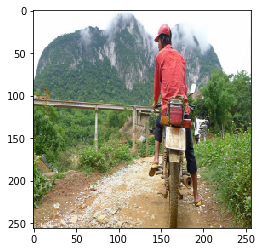

In [10]:
img = resize(img, (256, 256), mode='constant', anti_aliasing=True)
plt.imshow(img)
img.dtype

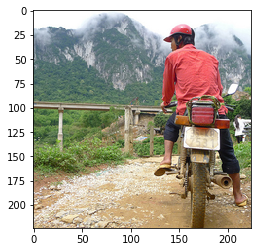

In [11]:
def resize_image(image):
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width
    image = image.crop((left, top, right, bottom))
    image = image.resize([224, 224], Image.ANTIALIAS)
    return image

img = Image.open(img_path) # int
rs_img = resize_image(img) # int
plt.imshow(rs_img)  # Information is lost because of cropping!

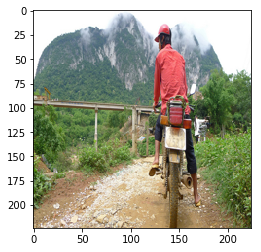

In [12]:
img = Image.open(img_path)
img = img.resize([224, 224], Image.BICUBIC)
plt.imshow(img)

In [13]:
def read_reshape_image(img_path):
    # Read images
    img = imageio.imread(img_path)

    # If image is gray scale then add channels
    if len(img.shape) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)

    # Resize image and return it
    img = resize(img, (224, 224), mode='constant', anti_aliasing=True)
    img = img.transpose(2, 0, 1)  # PyTorch: [C, W, H]
    return img

In [14]:
img_a = read_reshape_image(img_path)
img_a[0, 0, 0]

0.9303921568627898

In [15]:
def read_reshape_crop_image(img_path):
    # Read images
    img = Image.open(img_path)

    # Get cropping dimensions
    width, height = img.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width

    # Crop image
    img = img.crop((left, top, right, bottom))
    img = img.resize([224, 224], Image.ANTIALIAS)
    img = np.array(img)/255.0
    return img

In [16]:
img_b = read_reshape_crop_image(img_path)
img_b_a = np.array(img_b)/255

In [17]:
img_b_a.shape, img_a.shape

((224, 224, 3), (3, 224, 224))

(224, 224, 3)
<START> a motorcycle sitting in the middle of a road next to a forest <END> <PAD> <PAD> <PAD>


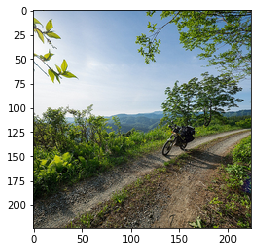

In [18]:
import json
with open('./WORD2IDX_COCO.json', 'r') as j:
    word2idx = json.load(j)
    
idx2word = {i:w for w, i in word2idx.items()}

IMG = data[0].squeeze(0).numpy()
IMG = IMG.transpose(1, 2, 0)
print(IMG.shape)

indices = data[1].squeeze(0).tolist()
print(' '.join([idx2word[i] for i in indices]))
plt.imshow(IMG)